In [24]:
!pip install rdkit-pypi

In [25]:
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import rdchem
import numpy as np
import pandas as pd
import re

import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [26]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Transformation prep

In [5]:
struct_len = 21
atom_len = 21

H_Vector = [0]*atom_len
H_Vector[0]= 1

Chiral = {"CHI_UNSPECIFIED":0,  "CHI_TETRAHEDRAL_CW":1, "CHI_TETRAHEDRAL_CCW":2, "CHI_OTHER":3}
Hybridization = {"UNSPECIFIED":0, "S":1, "SP":2, "SP2":3, "SP3":4, "SP3D":5, "SP3D2":6, "OTHER":7}

In [6]:
lowerReg = re.compile(r'^[a-z]+$')
def islower(s):
    return lowerReg.match(s) is not None

upperReg = re.compile(r'^[A-Z]+$')
def isupper(s):
    return upperReg.match(s) is not None

In [7]:
def atom_features(atom):
    
    if atom.GetSymbol() == 'H':
        feature = [1,0,0,0,0]
    elif atom.GetSymbol() == 'C':
        feature = [0,1,0,0,0]
    elif atom.GetSymbol() == 'O':
        feature = [0,0,1,0,0]
    elif atom.GetSymbol() == 'N':
        feature = [0,0,0,1,0]
    else:
        feature = [0,0,0,0,1]
        
    feature.append(atom.GetTotalNumHs()/8)
    feature.append(atom.GetTotalDegree()/4)
    feature.append(atom.GetFormalCharge()/8)
    feature.append(atom.GetTotalValence()/8)
    feature.append(atom.IsInRing()*1)
    feature.append(atom.GetIsAromatic()*1)

    f =  [0]*(len(Chiral)-1)
    if Chiral.get(str(atom.GetChiralTag()), 0) != 0:
        f[Chiral.get(str(atom.GetChiralTag()), 0)] = 1
    feature.extend(f)

    f =  [0]*(len(Hybridization)-1)
    if Hybridization.get(str(atom.GetHybridization()), 0) != 0:
        f[Hybridization.get(str(atom.GetHybridization()), 0)] = 1
    feature.extend(f)
    
    return feature

In [8]:
def structure_features(el, flag, label):
    feature = [0] * 21

    if el == '(' :
        feature[0] = 1
        flag = 0
    elif el == ')' :
        feature[1] = 1
        flag = 0
    elif el == '[' :
        feature[2] = 1
        flag = 0
    elif el == ']' :
        feature[3] = 1
        flag = 0
    elif el == '.' :
        feature[4] = 1
        flag = 0
    elif el == ':' :
        feature[5] = 1
        flag = 0
    elif el == '=' :
        feature[6] = 1
        flag = 0
    elif el == '#' :
        feature[7] = 1
        flag = 0
    elif el == '\\':
        feature[8] = 1
        flag = 0
    elif el == '/' :
        feature[9] = 1
        flag = 0  
    elif el == '@' :
        feature[10] = 1
        flag = 0
    elif el == '+' :
        feature[11] = 1
        flag = 1
    elif el == '-' :
        feature[12] = 1
        flag = 1
        
    elif el.isdigit() == True:
        if flag == 0:
            if el in label:
                feature[20] = 1
            else:
                label.append(el)
                feature[19] = 1
        else:
            feature[int(el)-1+12] = 1
            flag = 0
    return (feature, flag, label)

In [9]:
def smiles_to_feature(smi, MAX_LENGTH = 2800):
    mol = Chem.MolFromSmiles(smi)
    flag = 0
    label = []
    el_feature=[]
    mol_feature = []
    idx = 0
    j = 0
    
    for i, el in enumerate(smi):
        if islower(el) == True: 
            mol_feature.append([0]*42)
            continue
        elif isupper(el) == True:
            if el == 'H':
                el_feature.extend(H_Vector)
            else:
                el_feature.extend(atom_features(rdchem.Mol.GetAtomWithIdx(mol, idx)))
                idx = idx + 1
            el_feature.extend([0] * struct_len)
            j = j +1
            
        else:   
            el_feature.extend([0] * atom_len)
            f, flag, label = structure_features(el, flag, label)
            el_feature.extend(f)
            j = j +1
  
        mol_feature.append(el_feature)
        el_feature = []
        
    while(len(mol_feature) != MAX_LENGTH):
        mol_feature.append([0]*42)
        
    mol_feature = [np.array(lst) for lst in mol_feature]
    mol_feature = np.stack(mol_feature)
    return mol_feature

## Working with data

In [10]:
df = pd.read_csv('/content/drive/MyDrive/course/df_smiles_features.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head(6)

,pdbcode,affinity,pocket_smiles
0,3zzf,0.40,CC(C)C[C@@H](C=O)NC(=O)[C@H](CO)NC(=O)[C@@H](N...
1,3gww,0.45,CC(C)C[C@H](N)C(=O)N[C@H](C=O)Cc1ccc(O)cc1.CC(...
2,1w8l,0.49,CC(C)C[C@@H](C=O)NC(=O)[C@@H](N)Cc1c[nH]c2cccc...
3,3fqa,0.49,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](C)...
4,1zsb,0.60,CC(C)C[C@@H](C=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@@...
5,6h9v,0.66,CC[C@H](C)[C@H](N)C(=O)N[C@@H](CCC(N)=O)C(=O)N...


In [ ]:
drop_list = []

for i, smi in enumerate(df.pocket_smiles.values):
  try: 
    tmp = smiles_to_feature(smi)
    print(i, tmp.shape)
  except: 
    drop_list.append(i)


In [ ]:
len(drop_list)

778

In [ ]:
df.drop(index = drop_list, axis = 0, inplace = True)
df.reset_index(drop=True, inplace = True)
df.shape

(18635, 3)

In [11]:
max([len(smi) for smi in df.pocket_smiles.values])

2614

In [ ]:
y = df.drop(columns = ['pocket_smiles']).copy()
x = df.drop(columns = ['affinity']).copy()

In [12]:
df_train = pd.read_csv('/content/drive/MyDrive/course/df_train.csv')
df_train.drop(columns = ['Unnamed: 0'], inplace = True)

df_val = pd.read_csv('/content/drive/MyDrive/course/df_val.csv')
df_val.drop(columns = ['Unnamed: 0'], inplace = True)

In [13]:
partition = {'train': df_train.pdbcode.values,
             'val': df_val.pdbcode.values}
labels = {}
for code in df.pdbcode:
  labels.update({code: df[df.pdbcode == code].affinity.values[0]})

In [ ]:
df.to_csv('/content/drive/MyDrive/Course_work/notebooks/data/df_smiles_features.csv')

## Data Generator

In [14]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(2800,42), shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            smi = df[df.pdbcode == ID].pocket_smiles.values[0]
            X[i,] = smiles_to_feature(smi)
            #X[i,] = X[i,].reshape(self.dim[0], self.dim[1], 1)

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [15]:
train_generator = DataGenerator(partition['train'], labels)
val_generator = DataGenerator(partition['val'], labels)

## CNN implementation

In [16]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

import os
import time
import keras.backend as K

In [17]:
input_shape = (2800, 42, 1)

In [18]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [19]:
##model building
model = Sequential()
model.add(Conv2D(32, kernel_size=(64, 32),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (16, 8), activation='relu'))
model.add(MaxPooling2D(pool_size=(8, 4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='linear'))

In [20]:
model.compile(loss='mean_absolute_error',
              optimizer=tf.optimizers.SGD(lr=0.01),
              metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2737, 11, 32)      65568     
                                                                 
 conv2d_1 (Conv2D)           (None, 2722, 4, 64)       262208    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 340, 1, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 340, 1, 64)        0         
                                                                 
 flatten (Flatten)           (None, 21760)             0         
                                                                 
 dense (Dense)               (None, 128)               2785408   
                                                        

In [22]:
model.load_weights('/content/drive/MyDrive/course/cnn1.h5')

In [21]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [29]:
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

Epoch 1/10
407/407 [==============================] - 457s 1s/step - loss: 0.4989 - mean_absolute_error: 0.4989 - val_loss: 1.2168 - val_mean_absolute_error: 1.2168
Epoch 2/10
407/407 [==============================] - 456s 1s/step - loss: 0.4941 - mean_absolute_error: 0.4941 - val_loss: 1.2097 - val_mean_absolute_error: 1.2097
Epoch 3/10
407/407 [==============================] - 459s 1s/step - loss: 0.4851 - mean_absolute_error: 0.4851 - val_loss: 1.2096 - val_mean_absolute_error: 1.2096
Epoch 4/10
407/407 [==============================] - 458s 1s/step - loss: 0.4730 - mean_absolute_error: 0.4730 - val_loss: 1.2124 - val_mean_absolute_error: 1.2124
Epoch 5/10
407/407 [==============================] - 459s 1s/step - loss: 0.4669 - mean_absolute_error: 0.4669 - val_loss: 1.2087 - val_mean_absolute_error: 1.2087
Epoch 6/10
407/407 [==============================] - 459s 1s/step - loss: 0.4641 - mean_absolute_error: 0.4641 - val_loss: 1.2151 - val_mean_absolute_error: 1.2151
Epoch 7/10

In [30]:
pred_train = model.predict(train_generator)
pred_val = model.predict(val_generator)

In [31]:
y_train = []
y_val = []

for code in partition['train']:
  y_train.append(labels[code])

for code in partition['val']:
  y_val.append(labels[code])

y_train = np.array(y_train)
y_val = np.array(y_val)

In [33]:
pred_val = np.append(pred_val, [0])

In [35]:
df_val['cnn40'] = pred_val
df_val.to_csv('/content/drive/MyDrive/course/df_val.csv')

In [44]:
pred_val.shape

(3744,)

In [37]:
y_val = y_val[:-1]
y_train = y_train[:13024]
pred_val = pred_val[:-1]

In [38]:
print('mae, rmse:')
print('train:', mean_absolute_error(y_train, pred_train), mean_squared_error(y_train, pred_train, squared = False))
print('val:', mean_absolute_error(y_val, pred_val), mean_squared_error(y_val, pred_val, squared = False))

mae, rmse:
train: 0.6446410602909635 0.7842923237292763
val: 1.266125916482037 1.5949486091796525


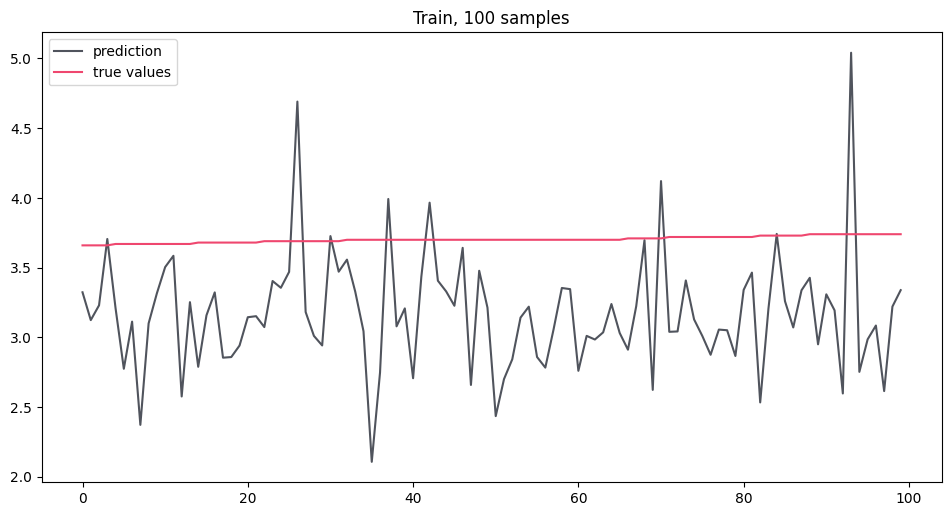

In [40]:
df_train_draw = pd.DataFrame({'code' : partition['train'][:13024], 
                      'affinity' : y_train,
                      'prediction' : np.reshape(pred_train, (pred_train.shape[0],))})
df_train_draw.sort_values(by = 'affinity', inplace = True)

fig = plt.figure(figsize=(10, 5),dpi=100)
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.plot(range(100), df_train_draw.prediction[1000:1100], color = '#50545D', label = 'prediction')
ax.plot(range(100), df_train_draw.affinity[1000:1100], color = '#EF476F', label = 'true values')
ax.set_title('Train, 100 samples')
ax.legend()

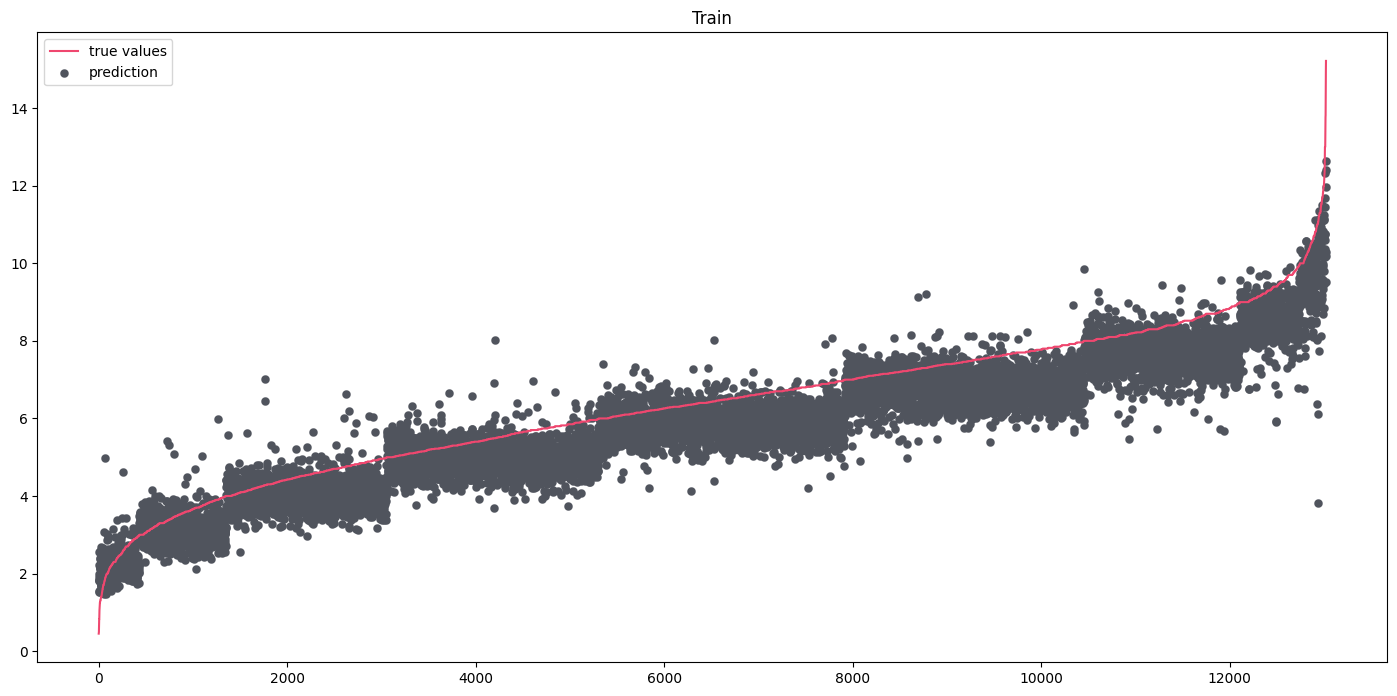

In [42]:
fig = plt.figure(figsize=(15, 7),dpi=100)
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.scatter(range(13024), df_train_draw.prediction, color = '#50545D', label = 'prediction', linewidth = 0.1)
ax.plot(range(13024), df_train_draw.affinity, color = '#EF476F', label = 'true values')
ax.set_title('Train')
ax.legend()

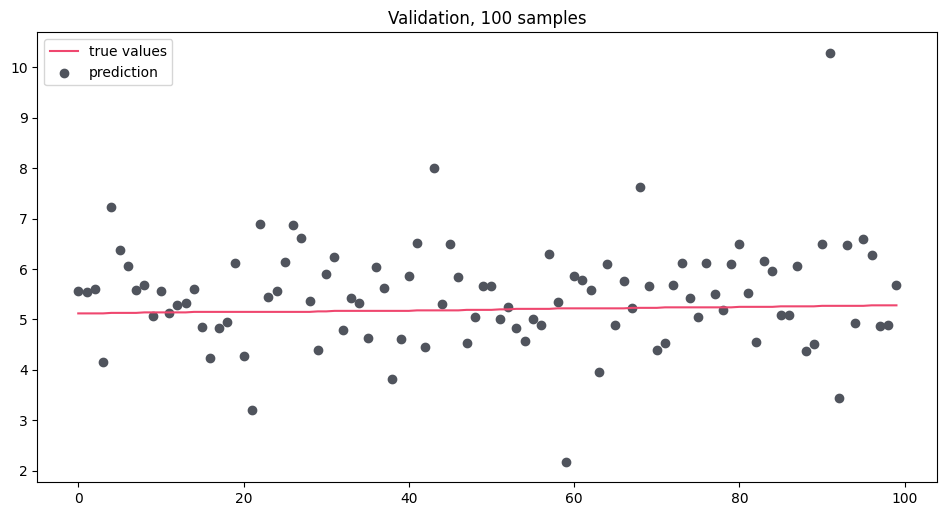

In [43]:
df_val_draw = pd.DataFrame({'code' : partition['val'][:-1], 
                      'affinity' : y_val,
                      'prediction' : np.reshape(pred_val, (pred_val.shape[0],))})
df_val_draw.sort_values(by = 'affinity', inplace = True)

fig = plt.figure(figsize=(10, 5),dpi=100)
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.scatter(range(100), df_val_draw.prediction[1000:1100], color = '#50545D', label = 'prediction')
ax.plot(range(100), df_val_draw.affinity[1000:1100], color = '#EF476F', label = 'true values')
ax.set_title('Validation, 100 samples')
ax.legend()

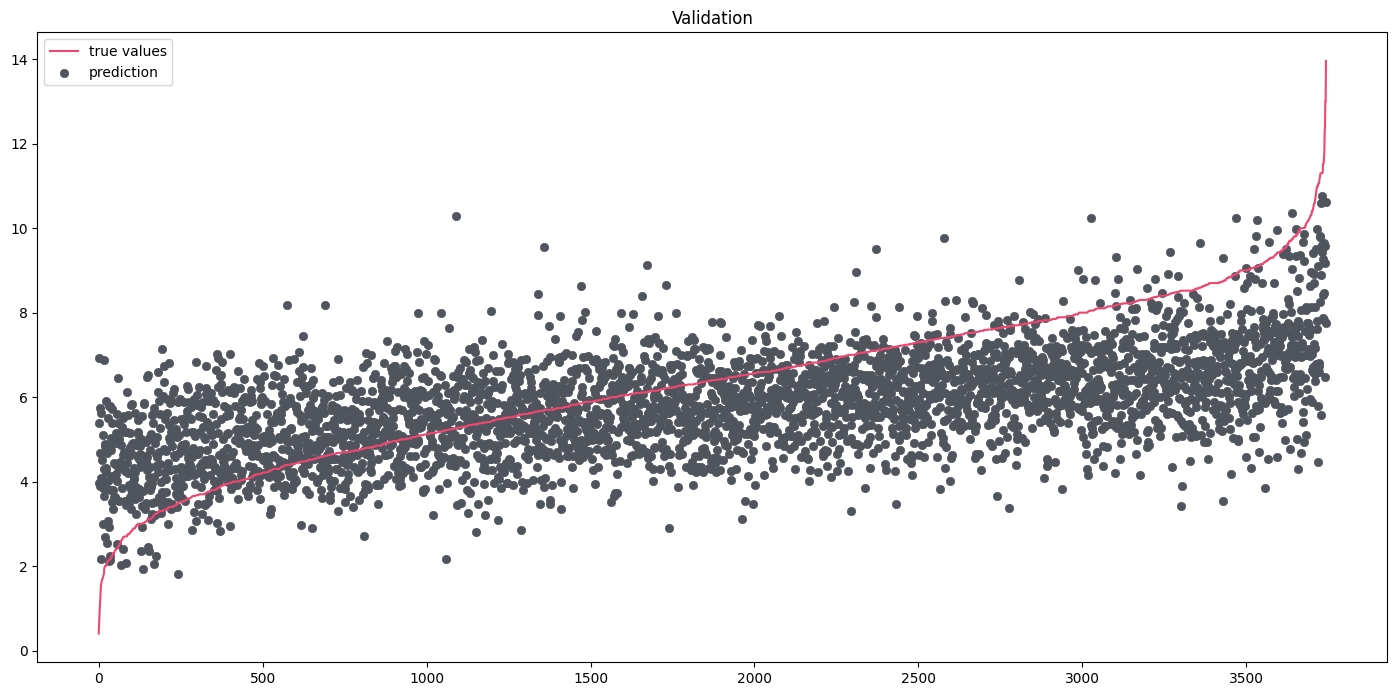

In [45]:
fig = plt.figure(figsize=(15, 7),dpi=100)
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.scatter(range(3744), df_val_draw.prediction, color = '#50545D', label = 'prediction', linewidth = 0.5)
ax.plot(range(3744), df_val_draw.affinity, color = '#EF476F', label = 'true values')
ax.set_title('Validation')
ax.legend()

In [46]:
model.save_weights('/content/drive/MyDrive/course/cnn40.h5')